In [2]:
import geopandas as gpd
import pandas as pd
import rasterio
from rasterio.mask import mask
from shapely.geometry import box
import numpy as np
import json
import os
import matplotlib.pyplot as plt


In [2]:
# Function to add a layer to the GeoPackage
def add_layer(gpkg_path, layer_name, gdf):
    modes = ['a', 'w']
    for mode in modes:
        try:
            gdf.to_file(gpkg_path, layer=layer_name, driver="GPKG", mode=mode)
            return True
        except:
            pass
    return False




In [3]:
# Path to the folder containing the data
data_folder = r"C:\Users\bsf31\Documents\post-meds\data\policy-data\data _q1"
output_gpkg = 'consolidated_data_q1.gpkg'


In [ ]:
# Remove the existing GeoPackage if it exists
if os.path.exists(output_gpkg):
    os.remove(output_gpkg)

# Walk through the folder and process files
for root, dirs, files in os.walk(data_folder):
    for file in files:
        file_path = os.path.join(root, file)
        if file.endswith('.shp') or file.endswith('.gpkg'):
            try:
                gdf = gpd.read_file(file_path)
                layer_name = os.path.splitext(file)[0]
                if not add_layer(output_gpkg, layer_name, gdf):
                    print(f"Skipping layer {layer_name} due to errors")
            except Exception as e:
                print(f"Error processing file {file_path}: {e}")

print(f"All layers consolidated into {output_gpkg}")

In [ ]:
# Function to add a raster layer to the GeoPackage
def add_raster_layer(gpkg_path, layer_name, raster_path):
    with rasterio.open(raster_path) as src:
        profile = src.profile
        profile['driver'] = 'PNG'  # Specify the desired raster format (e.g., PNG, JPEG, TIFF)
        
        with rasterio.open(gpkg_path, 'w', **profile) as dst:
            dst.write(src.read())

# Path to the folder containing the raster data
raster_folder = r"C:\Users\bsf31\Documents\post-meds\data\policy-data\raster_data"

In [3]:
# Path to the existing consolidated GeoPackage
consolidated_gpkg = r"C:\Users\bsf31\Documents\post-meds\data\policy-data\consolidated_data_q1.gpkg"


In [ ]:
# Walk through the raster folder and process files
for root, dirs, files in os.walk(raster_folder):
    for file in files:
        file_path = os.path.join(root, file)
        layer_name = os.path.splitext(file)[0]
        
        if file.endswith('.tif') or file.endswith('.png') or file.endswith('.jpg'):
            try:
                add_raster_layer(consolidated_gpkg, layer_name, file_path)
                print(f"Raster layer {layer_name} added to {consolidated_gpkg}")
            except Exception as e:
                print(f"Error processing raster file {file_path}: {e}")

print(f"All raster layers added to {consolidated_gpkg}")

In [4]:
study_boundary = gpd.read_file(consolidated_gpkg, layer_name= 'study_boundary')

In [ ]:

'''# Calculate forest area for each year
def calculate_forest_area(year):
    print(f"Calculating forest area for year {year}...")
    file_path = f"C:/Users/bsf31/Documents/post-meds/data/policy-data/raw-hansen/tc-years/updated_tree_cover_{year}.tif"
    with rasterio.open(file_path) as src:

        # Get the CRS of the raster
        raster_crs = src.crs
        
        # Reproject the study boundary to match the raster CRS
        study_boundary_reprojected = study_boundary.to_crs(raster_crs)
        

        # Crop the raster to the study boundary
        # Get the geometry of the study boundary (assuming there is only one feature)
        geometry = study_boundary_reprojected.geometry.values[0]

        # Create a bounding box (bbox) from the geometry bounds
        # box() creates a rectangular polygon from the min/max coordinates
        bbox = box(*geometry.bounds)

        # Create a GeoDataFrame with the bounding box geometry
        # The GeoDataFrame has a single feature with index 0 and the same CRS as the study boundary
        geo = gpd.GeoDataFrame({'geometry': bbox}, index=[0], crs=study_boundary_reprojected.crs)

        # Convert the GeoDataFrame to GeoJSON format and extract the geometry coordinates
        # The coordinates are stored as a list with a single element (the first feature's geometry)
        coords = [json.loads(geo.to_json())['features'][0]['geometry']]

        # Read the entire raster to count total pixels before cropping
        raster_data = src.read(1)
        total_pixels_before_crop = raster_data.size
        print(f"Total pixels before cropping: {total_pixels_before_crop}")

        # Crop the raster using the mask() function from rasterio
        # dataset: The raster dataset to be cropped (src)
        # shapes: The geometry coordinates used for cropping (coords)
        # crop: Set to True to crop the raster to the extent of the geometry
        # out_img: The cropped raster data as a numpy array
        # out_transform: The affine transformation of the cropped raster
        out_img, out_transform = mask(dataset=src, shapes=coords, crop=True)
        
        # Count the total pixels after cropping
        total_pixels_after_crop = out_img.size
        print(f"Total pixels after cropping: {total_pixels_after_crop}")
        # Replace masked values with a large negative number for easier processing
        out_img = np.ma.masked_equal(out_img, src.nodata).filled(-9999)
        
        # Calculate forest area in hectares
        forest_pixels = np.sum(out_img == 1)
        print(f"Number of forest pixels: {forest_pixels}")
        
        pixel_area_ha = (30 * 30) / 10000  # 30m resolution, convert to hectares
        forest_area_ha = forest_pixels * pixel_area_ha

        print(f"Forest area calculation for year {year} completed.")
        return forest_area_ha'''

In [3]:
# Calculate forest area for each year
def calculate_forest_area(year):
    print(f"Calculating forest area for year {year}...")
    file_path = f"C:/Users/bsf31/Documents/post-meds/data/policy-data/raw-hansen/tc-years/updated_tree_cover_{year}.tif"
    with rasterio.open(file_path) as src:

        # Read the raster data
        out_img = src.read(1)

        # Calculate forest area in hectares
        forest_pixels = np.sum(out_img == 1)
        print(f"Number of forest pixels: {forest_pixels}")
        
        pixel_area_ha = 30 * 30 / 10000  # 30m resolution, convert to hectares
        forest_area_ha = forest_pixels * pixel_area_ha

        print(f"Forest area calculation for year {year} completed.")
        return forest_area_ha

In [ ]:
# Calculate forest area for each year from 2000 to 2022
years = range(2000, 2023)
forest_areas = [calculate_forest_area(year) for year in years]

# Create a DataFrame with the results
forest_area_df = pd.DataFrame({'Year': years, 'Hectares': forest_areas})

In [ ]:
forest_area_df

In [ ]:
84543 * 900

In [ ]:
233778720 * 900 


In [ ]:
210400848000 / 10000

In [ ]:
# Save the DataFrame as a .csv file
forest_area_df.to_csv("forest_area_hectares_2000_2022.csv", index=False)

In [ ]:
# Plot the results
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(years, forest_areas, marker='o')
plt.xlabel('Year')
plt.ylabel('Forest Area (Hectares)')
plt.title('Forest Cover in Hectares (2000-2022)')
plt.grid(True)
plt.tight_layout()
plt.show()

In [3]:
# Read the layers from the GeoPackage
study_boundary = gpd.read_file(consolidated_gpkg, layer ='study_boundary')
departamento = gpd.read_file(consolidated_gpkg, layer="departamento")
dissolved_road = gpd.read_file(consolidated_gpkg, layer="dissolved_road")
distritos = gpd.read_file(consolidated_gpkg, layer="distritos")
protected_areas = gpd.read_file(consolidated_gpkg, layer="Protected_Areas")
river_buffer = gpd.read_file(consolidated_gpkg, layer="river_buffer")
river_buffer = river_buffer.to_crs("EPSG:4326")
indigenous_land = gpd.read_file(consolidated_gpkg, layer="indigenous_land")


In [10]:

# Define the years for analysis
years = [2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022]

In [7]:
combined_protected_areas = gpd.read_file(consolidated_gpkg, layer="combined_protected_areas")


In [ ]:
combined_protected_areas

In [9]:
# Define the function to calculate forest area within a given geometry
def calculate_forest_area(geometry, raster_path):
    with rasterio.open(raster_path) as src:
        out_img, _ = mask(src, [geometry], crop=True)
        forest_pixels = (out_img == 1).sum()
        pixel_area_ha = 30 * 30 / 10000  # 30m resolution, convert to hectares
        forest_area_ha = forest_pixels * pixel_area_ha
        return forest_area_ha

# Dissolved Bosques and AA

In [ ]:
# Preprocess the data and add dissolved layers to the GeoPackage
for year in years:
    print(year)
    # Read the active_lup layer for the current year
    active_lup = gpd.read_file(consolidated_gpkg, layer=f"active_lup_{year}")
    
    # Reproject the active_lup layer to match the CRS of the other layers
    active_lup = active_lup.to_crs('EPSG:4326')
    
    # Read the lup layer
    lup = gpd.read_file(consolidated_gpkg, layer="lup")
    
    # Filter the lup layer based on the active_lup layer
    active_lup_ids = active_lup["put_id"].unique()
    lup_filtered = lup[lup["put_id"].isin(active_lup_ids)]
    
    # Create a dissolved layer for "Bosques"
    print('bosques')
    bosques_dissolved = lup_filtered[lup_filtered["grupo"] == "BOSQUES"].dissolve()
    bosques_dissolved.to_file(consolidated_gpkg, layer=f"bosques_dissolved_{year}", driver="GPKG")
    
    # Create a dissolved layer for "Area_Autorizada"
    print('AA')
    area_autorizada_dissolved = lup_filtered[lup_filtered["grupo"] == "AREA_AUTORIZADA"].dissolve()
    area_autorizada_dissolved.to_file(consolidated_gpkg, layer=f"area_autorizada_dissolved_{year}", driver="GPKG")


# Yearly LUPs


In [ ]:
for year in years:
    print(year)
    # Read the active_lup layer for the current year
    active_lup = gpd.read_file(consolidated_gpkg, layer=f"active_lup_{year}")
    
    # Reproject the active_lup layer to match the CRS of the other layers
    active_lup = active_lup.to_crs('EPSG:4326')
    
    # Read the lup layer
    lup = gpd.read_file(consolidated_gpkg, layer="lup")
    
    # Filter the lup layer based on the active_lup layer
    active_lup_ids = active_lup["put_id"].unique()
    lup_filtered = lup[lup["put_id"].isin(active_lup_ids)]

    output_file= f"lup_{year}"
    # Save the filtered lup layer as a separate file for each year
    lup_filtered.to_file(consolidated_gpkg, layer=output_file, driver="GPKG")
    print(f"Saved {output_file}")

# Undeveloped

In [4]:
for year in years:
    print(f"Creating exclude layers for {year}...")
    
    # Read the active_lup layer for the current year
    active_lup = gpd.read_file(consolidated_gpkg, layer=f"active_lup_{year}")
    
    # Reproject the active_lup layer to match the CRS of the other layers
    active_lup = active_lup.to_crs('EPSG:4326')
    
    # Combine the geometries of the layers to exclude
    exclude_layers = gpd.GeoDataFrame(geometry=pd.concat([
        protected_areas.geometry,
        indigenous_land.geometry,
        active_lup.geometry,
        dissolved_road.geometry,
        river_buffer.geometry]))
    
    exclude_dissolved = exclude_layers.dissolve()
    
    # Perform a single difference operation
    undeveloped_area = study_boundary.difference(exclude_dissolved.geometry)
    
    # Save the undeveloped area as a separate file for each year
    output_file = f"undeveloped_area_{year}"
    undeveloped_area.to_file(consolidated_gpkg, layer=output_file, driver="GPKG")
    print(f"Exclude layers created and saved as {output_file}")

Creating exclude layers for 2000...


In [ ]:
'''print(f"creating undeveloped_forest_area...")

    # Combine the geometries of the layers to exclude
    exclude_layers = gpd.GeoDataFrame(geometry=pd.concat([
    protected_areas.geometry,
    indigenous_land.geometry,
    active_lup.geometry,
    dissolved_road.geometry,
    river_buffer.geometry]))

    exclude_dissolved  = exclude_layers.dissolve()

    # Perform a single difference operation
    undeveloped_area = study_boundary.difference(exclude_dissolved.geometry)
    
    # Calculate forest area within "undeveloped" areas

    print(f"calculate_forest_area undeveloped_forest_area...")
    undeveloped_forest_area = calculate_forest_area(undeveloped_area, f"C:/Users/bsf31/Documents/post-meds/data/policy-data/raw-hansen/tc-years/updated_tree_cover_{year}.tif")'''

In [7]:
""" # Initialize a dictionary to store the results
results = {}

for year in years:
    print(f"Calculating {year}...")

    # Read the dissolved layers for the current year from the GeoPackage
    bosques_dissolved = gpd.read_file(consolidated_gpkg, layer=f"bosques_dissolved_{year}")
    area_autorizada_dissolved = gpd.read_file(consolidated_gpkg, layer=f"area_autorizada_dissolved_{year}")
    print(f"Calculating protected_forest_area...")
    # Calculate forest area within public protected areas
    protected_forest_area = calculate_forest_area(protected_areas.unary_union, f"C:/Users/bsf31/Documents/post-meds/data/policy-data/raw-hansen/tc-years/updated_tree_cover_{year}.tif")
    print(f"Calculating indigenous_forest_area...")
    # Calculate forest area within indigenous territories
    indigenous_forest_area = calculate_forest_area(indigenous_land.unary_union, f"C:/Users/bsf31/Documents/post-meds/data/policy-data/raw-hansen/tc-years/updated_tree_cover_{year}.tif")
    print(f"Calculating active_lup...")
    # Calculate forest area within active LUPs as a whole
    active_lup = gpd.read_file(consolidated_gpkg, layer=f"active_lup_{year}")
    active_lup = active_lup.to_crs('EPSG:4326')
    active_lup_forest_area = calculate_forest_area(active_lup.unary_union, f"C:/Users/bsf31/Documents/post-meds/data/policy-data/raw-hansen/tc-years/updated_tree_cover_{year}.tif")
    print(f"Calculating protected_private_forest_area...")
    # Calculate forest area within private lands protected under PUT
    protected_private_forest_area = calculate_forest_area(bosques_dissolved.unary_union, f"C:/Users/bsf31/Documents/post-meds/data/policy-data/raw-hansen/tc-years/updated_tree_cover_{year}.tif")
    print(f"Calculating clearing_private_forest_area...")
    # Calculate forest area within private lands designated for clearing under PUT
    clearing_private_forest_area = calculate_forest_area(area_autorizada_dissolved.unary_union, f"C:/Users/bsf31/Documents/post-meds/data/policy-data/raw-hansen/tc-years/updated_tree_cover_{year}.tif")
    
    print(f" Store the results...")
    # Store the results for the current year
    results[year] = {
        "public_protected_areas": protected_forest_area,
        "indigenous_territories": indigenous_forest_area,
        "active_lup_areas": active_lup_forest_area,
        "private_lands_protected": protected_private_forest_area,
        "private_lands_clearing": clearing_private_forest_area,
        #"undeveloped_areas": undeveloped_forest_area
    } """




Calculating 2000...
Calculating protected_forest_area...
Calculating indigenous_forest_area...
Calculating active_lup...
Calculating protected_private_forest_area...
Calculating clearing_private_forest_area...
 Store the results...
Calculating 2001...
Calculating protected_forest_area...
Calculating indigenous_forest_area...
Calculating active_lup...
Calculating protected_private_forest_area...
Calculating clearing_private_forest_area...
 Store the results...
Calculating 2002...
Calculating protected_forest_area...
Calculating indigenous_forest_area...
Calculating active_lup...
Calculating protected_private_forest_area...
Calculating clearing_private_forest_area...
 Store the results...
Calculating 2003...
Calculating protected_forest_area...
Calculating indigenous_forest_area...
Calculating active_lup...
Calculating protected_private_forest_area...
Calculating clearing_private_forest_area...
 Store the results...
Calculating 2004...
Calculating protected_forest_area...
Calculating ind

In [12]:
# Initialize a dictionary to store the results
results = {}

for year in years:
    print(f"Calculating {year}...")

    # Read the dissolved layers for the current year from the GeoPackage
    bosques_dissolved = gpd.read_file(consolidated_gpkg, layer=f"bosques_dissolved_{year}")
    area_autorizada_dissolved = gpd.read_file(consolidated_gpkg, layer=f"area_autorizada_dissolved_{year}")

    print(f"Calculating protected_forest_area...")
    # Calculate forest area within public protected areas
    protected_forest_area = calculate_forest_area(combined_protected_areas.unary_union, f"C:/Users/bsf31/Documents/post-meds/data/policy-data/raw-hansen/tc-years/updated_tree_cover_{year}.tif")

    # Calculate forest area within active LUPs as a whole
    active_lup = gpd.read_file(consolidated_gpkg, layer=f"active_lup_{year}")
    active_lup = active_lup.to_crs('EPSG:4326')
    active_lup_forest_area = calculate_forest_area(active_lup.unary_union, f"C:/Users/bsf31/Documents/post-meds/data/policy-data/raw-hansen/tc-years/updated_tree_cover_{year}.tif")

    print(f"Calculating protected_private_forest_area...")
    # Calculate forest area within private lands protected under PUT
    protected_private_forest_area = calculate_forest_area(bosques_dissolved.unary_union, f"C:/Users/bsf31/Documents/post-meds/data/policy-data/raw-hansen/tc-years/updated_tree_cover_{year}.tif")
    
    print(f"Calculating clearing_private_forest_area...")
    # Calculate forest area within private lands designated for clearing under PUT
    clearing_private_forest_area = calculate_forest_area(area_autorizada_dissolved.unary_union, f"C:/Users/bsf31/Documents/post-meds/data/policy-data/raw-hansen/tc-years/updated_tree_cover_{year}.tif")
    
    print(f" Store the results...")
    # Store the results for the current year
    results[year] = {
        "public_protected_areas": protected_forest_area,
        "active_lup_areas": active_lup_forest_area,
        "private_lands_protected": protected_private_forest_area,
        "private_lands_clearing": clearing_private_forest_area,
        #"undeveloped_areas": undeveloped_forest_area
    }

Calculating 2000...
Calculating protected_forest_area...
Calculating protected_private_forest_area...
Calculating clearing_private_forest_area...
 Store the results...
Calculating 2001...
Calculating protected_forest_area...
Calculating protected_private_forest_area...
Calculating clearing_private_forest_area...
 Store the results...
Calculating 2002...
Calculating protected_forest_area...
Calculating protected_private_forest_area...
Calculating clearing_private_forest_area...
 Store the results...
Calculating 2003...
Calculating protected_forest_area...
Calculating protected_private_forest_area...
Calculating clearing_private_forest_area...
 Store the results...
Calculating 2004...
Calculating protected_forest_area...
Calculating protected_private_forest_area...
Calculating clearing_private_forest_area...
 Store the results...
Calculating 2005...
Calculating protected_forest_area...
Calculating protected_private_forest_area...
Calculating clearing_private_forest_area...
 Store the res

In [14]:
#Results
for year, result in results.items():
    print(f"Year: {year}")
    print(f"Forest area within public protected areas: {result['public_protected_areas']} ha")
    print(f"Forest area within active LUP areas: {result['active_lup_areas']} ha")
    print(f"Forest area within private lands protected under PUT: {result['private_lands_protected']} ha")
    print(f"Forest area within private lands designated for clearing under PUT: {result['private_lands_clearing']} ha")
    print("---")

Year: 2000
Forest area within public protected areas: 2777282.9099999997 ha
Forest area within active LUP areas: 890487.27 ha
Forest area within private lands protected under PUT: 208601.91 ha
Forest area within private lands designated for clearing under PUT: 164897.63999999998 ha
---
Year: 2001
Forest area within public protected areas: 2772921.69 ha
Forest area within active LUP areas: 997259.49 ha
Forest area within private lands protected under PUT: 254201.58 ha
Forest area within private lands designated for clearing under PUT: 202268.25 ha
---
Year: 2002
Forest area within public protected areas: 2769913.71 ha
Forest area within active LUP areas: 1151726.8499999999 ha
Forest area within private lands protected under PUT: 308905.38 ha
Forest area within private lands designated for clearing under PUT: 238572.36 ha
---
Year: 2003
Forest area within public protected areas: 2762544.33 ha
Forest area within active LUP areas: 1559934.3599999999 ha
Forest area within private lands prot

In [ ]:
results

In [3]:
results_parq = pd.read_parquet(r"C:\Users\bsf31\Documents\post-meds\github\PYForestPolicyImpact-ML\05-forest_cover\forest_cover_results2.parquet")

In [15]:
734721.2999999999 + 108505.70999999999

843227.0099999999

In [5]:
results_parq

,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,...,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022
0,"{'active_lup_areas': 890487.27, 'private_lands...","{'active_lup_areas': 997259.49, 'private_lands...","{'active_lup_areas': 1151726.8499999999, 'priv...","{'active_lup_areas': 1559934.3599999999, 'priv...","{'active_lup_areas': 2072578.77, 'private_land...","{'active_lup_areas': 2476339.83, 'private_land...","{'active_lup_areas': 3275685.27, 'private_land...","{'active_lup_areas': 3969212.13, 'private_land...","{'active_lup_areas': 4888753.38, 'private_land...","{'active_lup_areas': 5120295.84, 'private_land...",...,"{'active_lup_areas': 6011544.96, 'private_land...","{'active_lup_areas': 6518959.2, 'private_lands...","{'active_lup_areas': 6697308.87, 'private_land...","{'active_lup_areas': 6664107.51, 'private_land...","{'active_lup_areas': 6651948.239999999, 'priva...","{'active_lup_areas': 6728909.31, 'private_land...","{'active_lup_areas': 6766473.239999999, 'priva...","{'active_lup_areas': 6757164.989999999, 'priva...","{'active_lup_areas': 6712116.569999999, 'priva...","{'active_lup_areas': 6679564.29, 'private_land..."


In [6]:
df = results_parq.copy()
# Restructure the DataFrame
df_restructured = pd.DataFrame(df.iloc[0].tolist(), index=df.columns).T

In [7]:
df_restructured

,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,...,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022
active_lup_areas,890487.27,997259.49,1151726.85,1559934.36,2072578.77,2476339.83,3275685.27,3969212.13,4888753.38,5120295.84,...,6011544.96,6518959.20,6697308.87,6664107.51,6651948.24,6728909.31,6766473.24,6757164.99,6712116.57,6679564.29
private_lands_clearing,164897.64,202268.25,238572.36,339998.85,441315.63,525858.84,713052.72,691306.92,911421.18,923816.43,...,1278960.66,1470003.84,1531207.26,1496850.39,1448505.99,1335018.24,1304143.29,1253497.95,1179664.74,1151279.82
private_lands_protected,208601.91,254201.58,308905.38,432170.82,577277.73,720310.50,965659.05,990777.51,1252123.29,1352087.55,...,2131825.23,2446687.53,2652256.44,2706601.32,2757137.22,2863346.22,2899498.32,2935435.41,2811237.84,2832851.52
public_protected_areas,2777282.91,2772921.69,2769913.71,2762544.33,2759184.99,2754463.95,2752104.69,2739379.32,2725799.58,2715503.31,...,2653428.60,2642481.54,2634613.47,2626079.31,2617601.31,2611399.86,2578443.93,2575600.11,2571730.02,2566068.75


In [8]:
df_restructured = df_restructured.reset_index().rename(columns={'index': 'category'})
df_melted = df_restructured.melt(id_vars=['category'], var_name='year', value_name='area')


In [9]:
# Print the restructured DataFrame
print("Restructured DataFrame:")
print(df_melted)


Restructured DataFrame:
                   category  year        area
0          active_lup_areas  2000   890487.27
1    private_lands_clearing  2000   164897.64
2   private_lands_protected  2000   208601.91
3    public_protected_areas  2000  2777282.91
4          active_lup_areas  2001   997259.49
..                      ...   ...         ...
87   public_protected_areas  2021  2571730.02
88         active_lup_areas  2022  6679564.29
89   private_lands_clearing  2022  1151279.82
90  private_lands_protected  2022  2832851.52
91   public_protected_areas  2022  2566068.75

[92 rows x 3 columns]


In [22]:
# Calculate summary statistics
stats = df_melted.groupby('year')['area'].describe()
print("\nSummary Statistics:")
print(stats)


Summary Statistics:
      count          mean           std         min           25%  \
year                                                                
2000    4.0  1.010317e+06  1.223929e+06   164897.64  1.976758e+05   
2001    4.0  1.056663e+06  1.200418e+06   202268.25  2.412182e+05   
2002    4.0  1.117280e+06  1.177282e+06   238572.36  2.913221e+05   
2003    4.0  1.273662e+06  1.137037e+06   339998.85  4.091278e+05   
2004    4.0  1.462589e+06  1.137252e+06   441315.63  5.432872e+05   
2005    4.0  1.619243e+06  1.158578e+06   525858.84  6.716976e+05   
2006    4.0  1.926625e+06  1.277705e+06   713052.72  9.025075e+05   
2007    4.0  2.097669e+06  1.540295e+06   691306.92  9.159099e+05   
2008    4.0  2.444524e+06  1.809751e+06   911421.18  1.166948e+06   
2009    4.0  2.527926e+06  1.889562e+06   923816.43  1.245020e+06   
2010    4.0  2.630742e+06  1.923198e+06   990316.17  1.391656e+06   
2011    4.0  2.716957e+06  1.929615e+06  1048596.93  1.542592e+06   
2012    4.0  

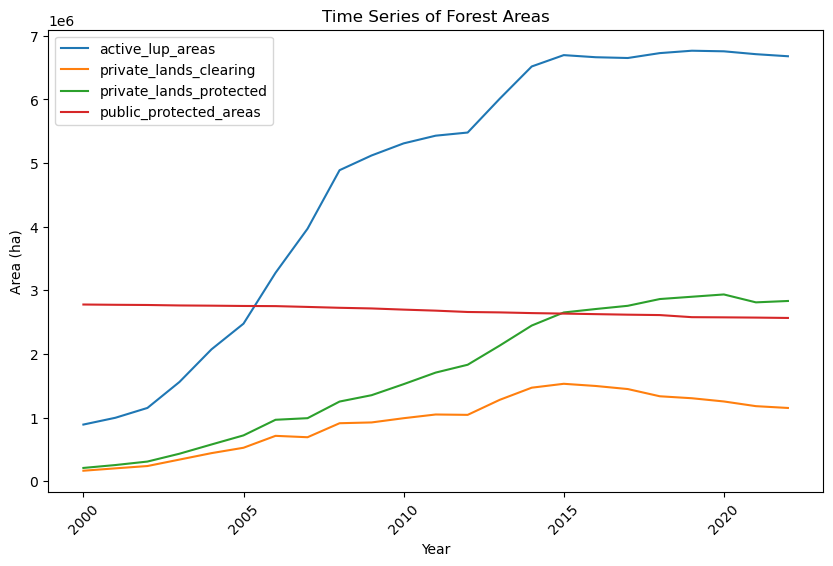

In [23]:
# Plot time series for each category
plt.figure(figsize=(10, 6))
for category in df_melted['category'].unique():
    data = df_melted[df_melted['category'] == category]
    plt.plot(data['year'], data['area'], label=category)
plt.xlabel('Year')
plt.ylabel('Area (ha)')
plt.title('Time Series of Forest Areas')
plt.legend()
plt.xticks(rotation=45)
plt.show()

In [24]:
# Pivot the DataFrame to convert categories to columns
df_pivoted = df_melted.pivot(index='year', columns='category', values='area')

In [25]:
df_pivoted

category,active_lup_areas,private_lands_clearing,private_lands_protected,public_protected_areas
year,,,,
2000,890487.27,164897.64,208601.91,2777282.91
2001,997259.49,202268.25,254201.58,2772921.69
2002,1151726.85,238572.36,308905.38,2769913.71
2003,1559934.36,339998.85,432170.82,2762544.33
2004,2072578.77,441315.63,577277.73,2759184.99
2005,2476339.83,525858.84,720310.50,2754463.95
2006,3275685.27,713052.72,965659.05,2752104.69
2007,3969212.13,691306.92,990777.51,2739379.32
2008,4888753.38,911421.18,1252123.29,2725799.58


In [26]:
# Calculate summary statistics
stats = df_pivoted.describe()
print("\nSummary Statistics:")
print(stats)


Summary Statistics:
category  active_lup_areas  private_lands_clearing  private_lands_protected  \
count         2.300000e+01            2.300000e+01             2.300000e+01   
mean          4.730958e+06            9.427600e+05             1.702709e+06   
std           2.174873e+06            4.451452e+05             1.002429e+06   
min           8.904873e+05            1.648976e+05             2.086019e+05   
25%           2.876013e+06            6.085829e+05             8.429848e+05   
50%           5.431000e+06            1.042926e+06             1.707257e+06   
75%           6.671836e+06            1.291552e+06             2.731869e+06   
max           6.766473e+06            1.531207e+06             2.935435e+06   

category  public_protected_areas  
count               2.300000e+01  
mean                2.680195e+06  
std                 7.360521e+04  
min                 2.566069e+06  
25%                 2.621840e+06  
50%                 2.680974e+06  
75%                 2.

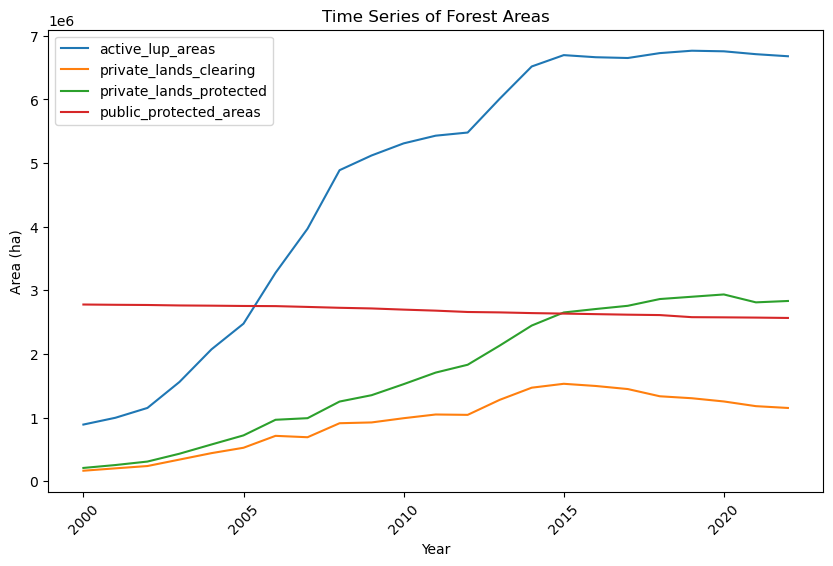

In [27]:
# Plot time series for each category
plt.figure(figsize=(10, 6))
for column in df_pivoted.columns:
    plt.plot(df_pivoted.index, df_pivoted[column], label=column)
plt.xlabel('Year')
plt.ylabel('Area (ha)')
plt.title('Time Series of Forest Areas')
plt.legend()
plt.xticks(rotation=45)
plt.show()

In [6]:

# Create a dataframe from the data
data = {
    'year': range(2000, 2023),
    'active_lup_areas': [890487.27, 997259.49, 1151726.85, 1559934.36, 2072578.77, 2476339.83, 3275685.27, 3969212.13, 4888753.38, 5120295.84, 5310100.62, 5430999.51, 5480553.78, 6011544.96, 6518959.20, 6697308.87, 6664107.51, 6651948.24, 6728909.31, 6766473.24, 6757164.99, 6712116.57, 6679564.29],
    'private_lands_clearing': [164897.64, 202268.25, 238572.36, 339998.85, 441315.63, 525858.84, 713052.72, 691306.92, 911421.18, 923816.43, 990316.17, 1048596.93, 1042925.67, 1278960.66, 1470003.84, 1531207.26, 1496850.39, 1448505.99, 1335018.24, 1304143.29, 1253497.95, 1179664.74, 1151279.82],
    'private_lands_protected': [208601.91, 254201.58, 308905.38, 432170.82, 577277.73, 720310.50, 965659.05, 990777.51, 1252123.29, 1352087.55, 1525435.29, 1707256.71, 1830612.06, 2131825.23, 2446687.53, 2652256.44, 2706601.32, 2757137.22, 2863346.22, 2899498.32, 2935435.41, 2811237.84, 2832851.52]
}

df = pd.DataFrame(data)

# Calculate total area with land use plans
df['total_lup_area'] = df['active_lup_areas']

# Calculate total deforested area
df['total_deforested_area'] = df['private_lands_clearing'] + df['private_lands_protected']

# Calculate percentage of LUP area that is protected (not deforested)
df['percentage_protected'] = (df['total_lup_area'] - df['total_deforested_area']) / df['total_lup_area'] * 100

# Display results
print(df[['year', 'total_lup_area', 'total_deforested_area', 'percentage_protected']])

# Calculate overall change in LUP and deforested areas
first_year_lup = df['total_lup_area'].iloc[0]
last_year_lup = df['total_lup_area'].iloc[-1]
lup_increase = ((last_year_lup - first_year_lup) / first_year_lup) * 100

first_year_deforested = df['total_deforested_area'].iloc[0]
last_year_deforested = df['total_deforested_area'].iloc[-1]
deforested_increase = ((last_year_deforested - first_year_deforested) / first_year_deforested) * 100

print(f"\nOverall increase in area with land use plans from 2000 to 2022: {lup_increase:.2f}%")
print(f"Overall increase in deforested area from 2000 to 2022: {deforested_increase:.2f}%")


    year  total_lup_area  total_deforested_area  percentage_protected
0   2000       890487.27              373499.55             58.056722
1   2001       997259.49              456469.83             54.227577
2   2002      1151726.85              547477.74             52.464620
3   2003      1559934.36              772169.67             50.499861
4   2004      2072578.77             1018593.36             50.853817
5   2005      2476339.83             1246169.34             49.676966
6   2006      3275685.27             1678711.77             48.752349
7   2007      3969212.13             1682084.43             57.621705
8   2008      4888753.38             2163544.47             55.744455
9   2009      5120295.84             2275903.98             55.551319
10  2010      5310100.62             2515751.46             52.623281
11  2011      5430999.51             2755853.64             49.256971
12  2012      5480553.78             2873537.73             47.568479
13  2013      601154

In [7]:
# Create the dataframe
data = {
    'year': range(2000, 2023),
    'active_lup_areas': [890487.27, 997259.49, 1151726.85, 1559934.36, 2072578.77, 2476339.83, 3275685.27, 3969212.13, 4888753.38, 5120295.84, 5310100.62, 5430999.51, 5480553.78, 6011544.96, 6518959.20, 6697308.87, 6664107.51, 6651948.24, 6728909.31, 6766473.24, 6757164.99, 6712116.57, 6679564.29],
    'private_lands_clearing': [164897.64, 202268.25, 238572.36, 339998.85, 441315.63, 525858.84, 713052.72, 691306.92, 911421.18, 923816.43, 990316.17, 1048596.93, 1042925.67, 1278960.66, 1470003.84, 1531207.26, 1496850.39, 1448505.99, 1335018.24, 1304143.29, 1253497.95, 1179664.74, 1151279.82],
    'private_lands_protected': [208601.91, 254201.58, 308905.38, 432170.82, 577277.73, 720310.50, 965659.05, 990777.51, 1252123.29, 1352087.55, 1525435.29, 1707256.71, 1830612.06, 2131825.23, 2446687.53, 2652256.44, 2706601.32, 2757137.22, 2863346.22, 2899498.32, 2935435.41, 2811237.84, 2832851.52]
}

df = pd.DataFrame(data)

# Calculate total deforested area
df['total_deforested'] = df['private_lands_clearing'] + df['private_lands_protected']

# Calculate percentage of LUP area that is protected (not deforested)
df['percentage_protected'] = (df['active_lup_areas'] - df['total_deforested']) / df['active_lup_areas'] * 100

# Calculate year-over-year growth rates
df['lup_growth_rate'] = df['active_lup_areas'].pct_change() * 100
df['deforested_growth_rate'] = df['total_deforested'].pct_change() * 100

# Calculate ratio of deforested to LUP areas
df['deforested_to_lup_ratio'] = df['total_deforested'] / df['active_lup_areas'] * 100

# Calculate ratio of clearing to protected deforestation
df['clearing_to_protected_ratio'] = df['private_lands_clearing'] / df['private_lands_protected']

# Function to calculate overall growth rate
def overall_growth_rate(start_value, end_value, years):
    return ((end_value / start_value) ** (1/years) - 1) * 100

# Calculate overall growth rates
years = df['year'].max() - df['year'].min()
lup_growth = overall_growth_rate(df['active_lup_areas'].iloc[0], df['active_lup_areas'].iloc[-1], years)
deforested_growth = overall_growth_rate(df['total_deforested'].iloc[0], df['total_deforested'].iloc[-1], years)
clearing_growth = overall_growth_rate(df['private_lands_clearing'].iloc[0], df['private_lands_clearing'].iloc[-1], years)
protected_deforested_growth = overall_growth_rate(df['private_lands_protected'].iloc[0], df['private_lands_protected'].iloc[-1], years)

# Print overall statistics
print(f"Overall growth rates (2000-2022):")
print(f"Active LUP areas: {lup_growth:.2f}%")
print(f"Total deforested area: {deforested_growth:.2f}%")
print(f"Private lands clearing: {clearing_growth:.2f}%")
print(f"Private lands protected (deforested): {protected_deforested_growth:.2f}%")

# Print key metrics for start and end years
print("\nKey metrics:")
print(f"2000: LUP area: {df['active_lup_areas'].iloc[0]:.2f}, Deforested: {df['total_deforested'].iloc[0]:.2f}, % Protected: {df['percentage_protected'].iloc[0]:.2f}%")
print(f"2022: LUP area: {df['active_lup_areas'].iloc[-1]:.2f}, Deforested: {df['total_deforested'].iloc[-1]:.2f}, % Protected: {df['percentage_protected'].iloc[-1]:.2f}%")

# Analyze phases
print("\nLUP Growth Phases:")
print(f"2000-2008 growth: {((df['active_lup_areas'][8] / df['active_lup_areas'][0]) - 1) * 100:.2f}%")
print(f"2009-2015 growth: {((df['active_lup_areas'][15] / df['active_lup_areas'][9]) - 1) * 100:.2f}%")
print(f"2016-2022 growth: {((df['active_lup_areas'][22] / df['active_lup_areas'][16]) - 1) * 100:.2f}%")

# Recent trends (2020-2022)
print("\nRecent trends (2020-2022):")
print(f"LUP areas change: {((df['active_lup_areas'].iloc[-1] / df['active_lup_areas'].iloc[-3]) - 1) * 100:.2f}%")
print(f"Private lands clearing change: {((df['private_lands_clearing'].iloc[-1] / df['private_lands_clearing'].iloc[-3]) - 1) * 100:.2f}%")
print(f"Private lands protected change: {((df['private_lands_protected'].iloc[-1] / df['private_lands_protected'].iloc[-3]) - 1) * 100:.2f}%")

# Find years with significant changes
significant_changes = df[abs(df['lup_growth_rate']) > df['lup_growth_rate'].mean() + df['lup_growth_rate'].std()]
print("\nYears with significant LUP area changes:")
print(significant_changes[['year', 'lup_growth_rate']])

# Correlation analysis
correlation = df[['active_lup_areas', 'private_lands_clearing', 'private_lands_protected', 'total_deforested']].corr()
print("\nCorrelation matrix:")
print(correlation)

Overall growth rates (2000-2022):
Active LUP areas: 9.59%
Total deforested area: 11.36%
Private lands clearing: 9.24%
Private lands protected (deforested): 12.59%

Key metrics:
2000: LUP area: 890487.27, Deforested: 373499.55, % Protected: 58.06%
2022: LUP area: 6679564.29, Deforested: 3984131.34, % Protected: 40.35%

LUP Growth Phases:
2000-2008 growth: 449.00%
2009-2015 growth: 30.80%
2016-2022 growth: 0.23%

Recent trends (2020-2022):
LUP areas change: -1.15%
Private lands clearing change: -8.15%
Private lands protected change: -3.49%

Years with significant LUP area changes:
   year  lup_growth_rate
3  2003        35.443084
4  2004        32.863204
6  2006        32.279311
8  2008        23.166846

Correlation matrix:
                         active_lup_areas  private_lands_clearing  \
active_lup_areas                 1.000000                0.973981   
private_lands_clearing           0.973981                1.000000   
private_lands_protected          0.961956                0.94